In [1]:
from tqdm.contrib import itertools
from simulation_util import calc_frequency

/Users/timschulz/Projects/Studium/bachelorarbeit/dql_task_adaptation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from EduKTM import DKT
import torch
import torch.utils.data as Data
from dkt.loader import transform_sim_data, parse_all_seq, encode_onehot

NUM_QUESTIONS = 123
HIDDEN_SIZE = 10
NUM_LAYERS = 1
BATCH_SIZE = 64

dkt = DKT(NUM_QUESTIONS, HIDDEN_SIZE, NUM_LAYERS)
dkt.load("./dkt/assistment-2009-2010-skilldkt.params")
model = dkt.dkt_model
model.eval()


def create_task_with_dkt_model(simulation_log, dql_model):
    transformed_data = transform_sim_data(simulation_log, dql_model).dropna(subset=['skill_id'])
    data = parse_all_seq(transformed_data)
    encoded = encode_onehot(data, NUM_QUESTIONS)
    data_loader = Data.DataLoader(encoded, shuffle=True)
    
    for batch in data_loader:
        integrated_pred = model(batch.to(torch.float32))
        task_count = integrated_pred.shape[1]
    return {
        category: [
            calc_frequency(
                integrated_pred[0][task_count-1][(category_i * len(dql_model[category])) + i].item()
            ) for i in range(len(dql_model[category]))
        ] for category_i, category in enumerate(dql_model)
    }



In [3]:
from simulation_util import add_delta_to_competency, calc_task_complexities, calculate_delta, create_learner_population, create_learner_scaffolded_competence_bonuses, create_optimal_task, create_random_task
from simulation_const import DQL_MODEL

MAX_TASK_COUNT = 100

def simulate_task_adaptation(learner_count: int, mean_competency: float, bonus_distribution: tuple[float, float, float, float], type: str = "optimal"):
    """
    Simulate task adaptation with different strategies for task creation.
    
    Args:
        learner_count: Number of learners to simulate
        mean_competency: Mean competency level for the learner population
        bonus_distribution: Tuple of 4 values for scaffolding bonus distribution
        task_type: Strategy for task creation ("optimal", "random", or "dkt")
    """
    if type not in ["optimal", "random", "dkt"]:
        raise ValueError("task_type must be one of: optimal, random, dkt")

    learner_population = create_learner_population(
        learner_count, MAX_TASK_COUNT, DQL_MODEL, mean_competency, bonus_distribution)

    simulationLog = []

    for i, j in itertools.product(range(learner_count), range(MAX_TASK_COUNT)):

        learner_competency = learner_population["learner_competencies"][i]
        scaffolding_bonus = learner_population["scaffolding_competence_bonus_per_step_and_learner"][j][i]
        
        # Create task based on selected strategy
        if type == "optimal":
            task = create_optimal_task(DQL_MODEL, learner_competency, scaffolding_bonus)
        elif type == "random":
            task = create_random_task(DQL_MODEL)
        elif type == "dkt":
            # First task is random since there's no previous data
            if i == 0:
                task = create_random_task(DQL_MODEL)
            else:
                competency = create_task_with_dkt_model([simulationLog[i-1]], DQL_MODEL)
                bonus = create_learner_scaffolded_competence_bonuses(DQL_MODEL, bonus_distribution)
                task = {
                    category: [
                        competency[category][i] + bonus[category][i]
                        for i in range(len(competency[category]))
                    ] for category in competency
                }

        task_complexities = calc_task_complexities(task)
        
        delta = calculate_delta(
            learner_competency, task_complexities, scaffolding_bonus)
        
        # if i == 1:
        #     print("Old competency: ", learner_competency)
        #     print(delta)
        #     print("New competency: ", add_delta_to_competency(learner_competency, delta))
        #     print("\n")

        # update the learner competency in the global learner population
        learner_population["learner_competencies"][i] = add_delta_to_competency(
            learner_competency, delta)

        simulationLog.append({
            "tasks": [],
            "competencies": [],
            "scaffolding_bonuses": [],
            "deltas": []
        })
        simulationLog[i]["tasks"].append(task)
        simulationLog[i]["competencies"].append(learner_competency)
        simulationLog[i]["scaffolding_bonuses"].append(scaffolding_bonus)
        simulationLog[i]["deltas"].append(delta)
            
    return simulationLog

In [4]:
from simulation_plot import plot_mean_simulation_log, plot_simulation_log

log_optimal = simulate_task_adaptation(100, 0.5, (0.1, 0.002, 0, 0.2), type="optimal")
log_random = simulate_task_adaptation(100, 0.5, (0.1, 0.002, 0, 0.2), type="random")
log_dkt = simulate_task_adaptation(100, 0.5, (0.1, 0.002, 0, 0.2), type="dkt")


100%|██████████| 10000/10000 [02:08<00:00, 77.80it/s]


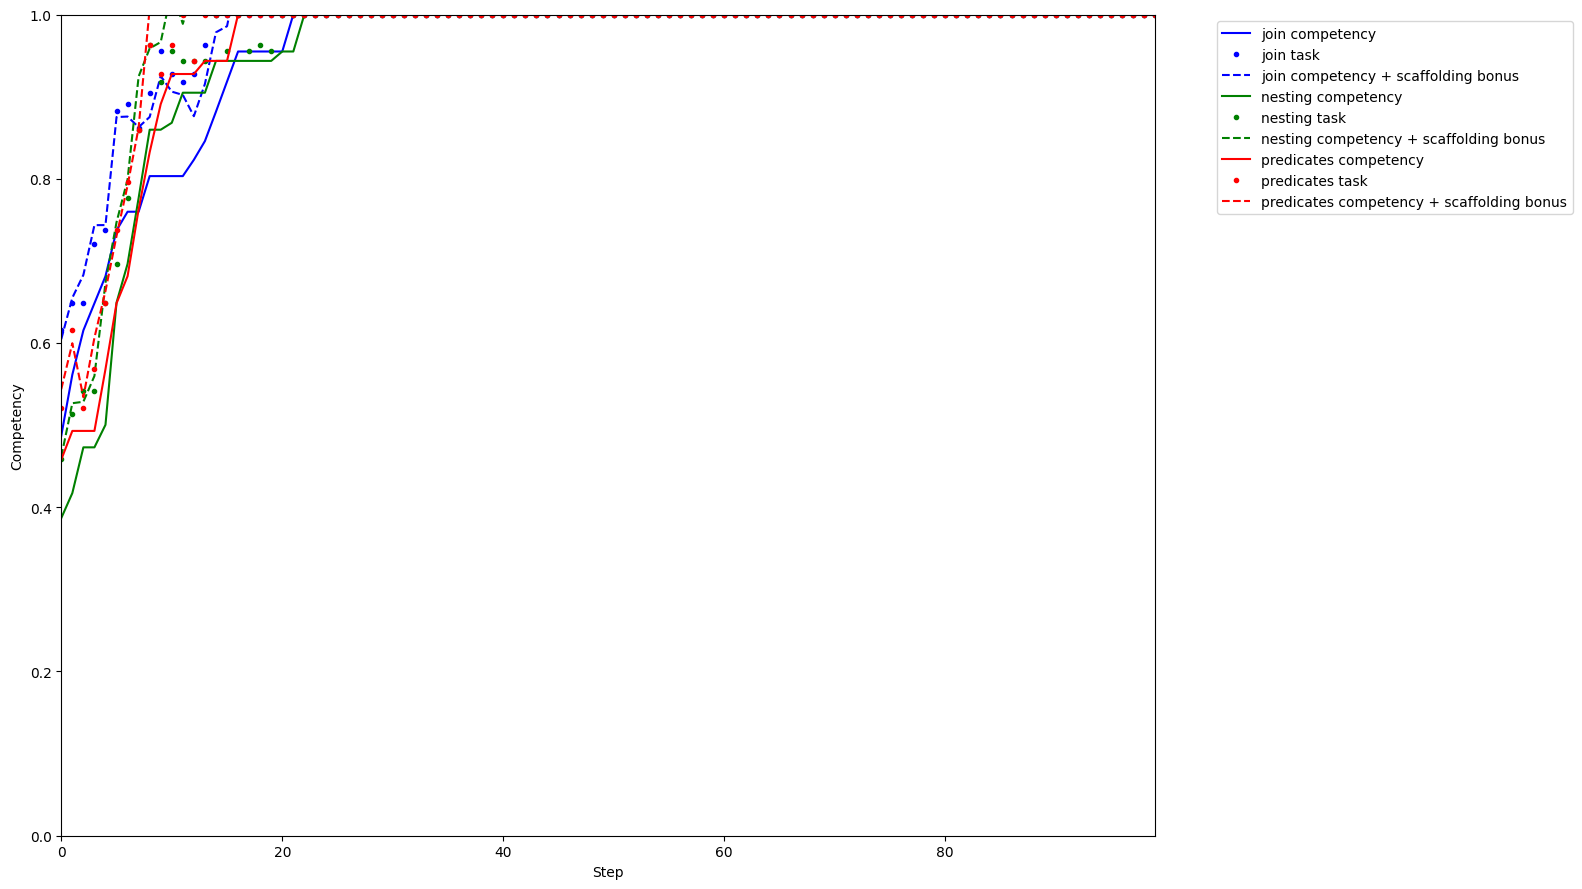

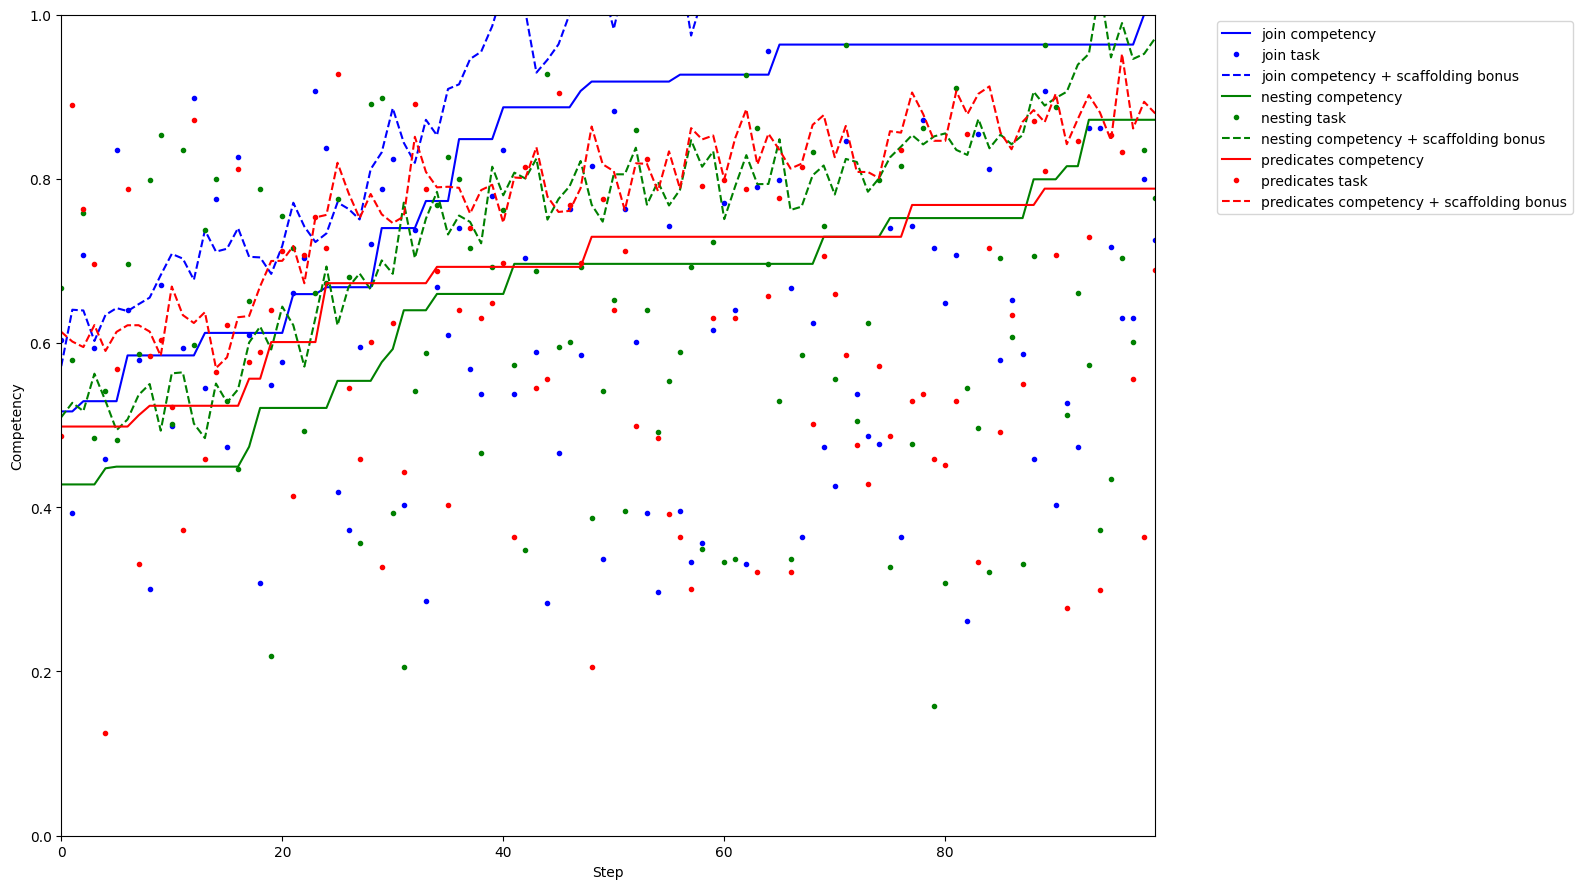

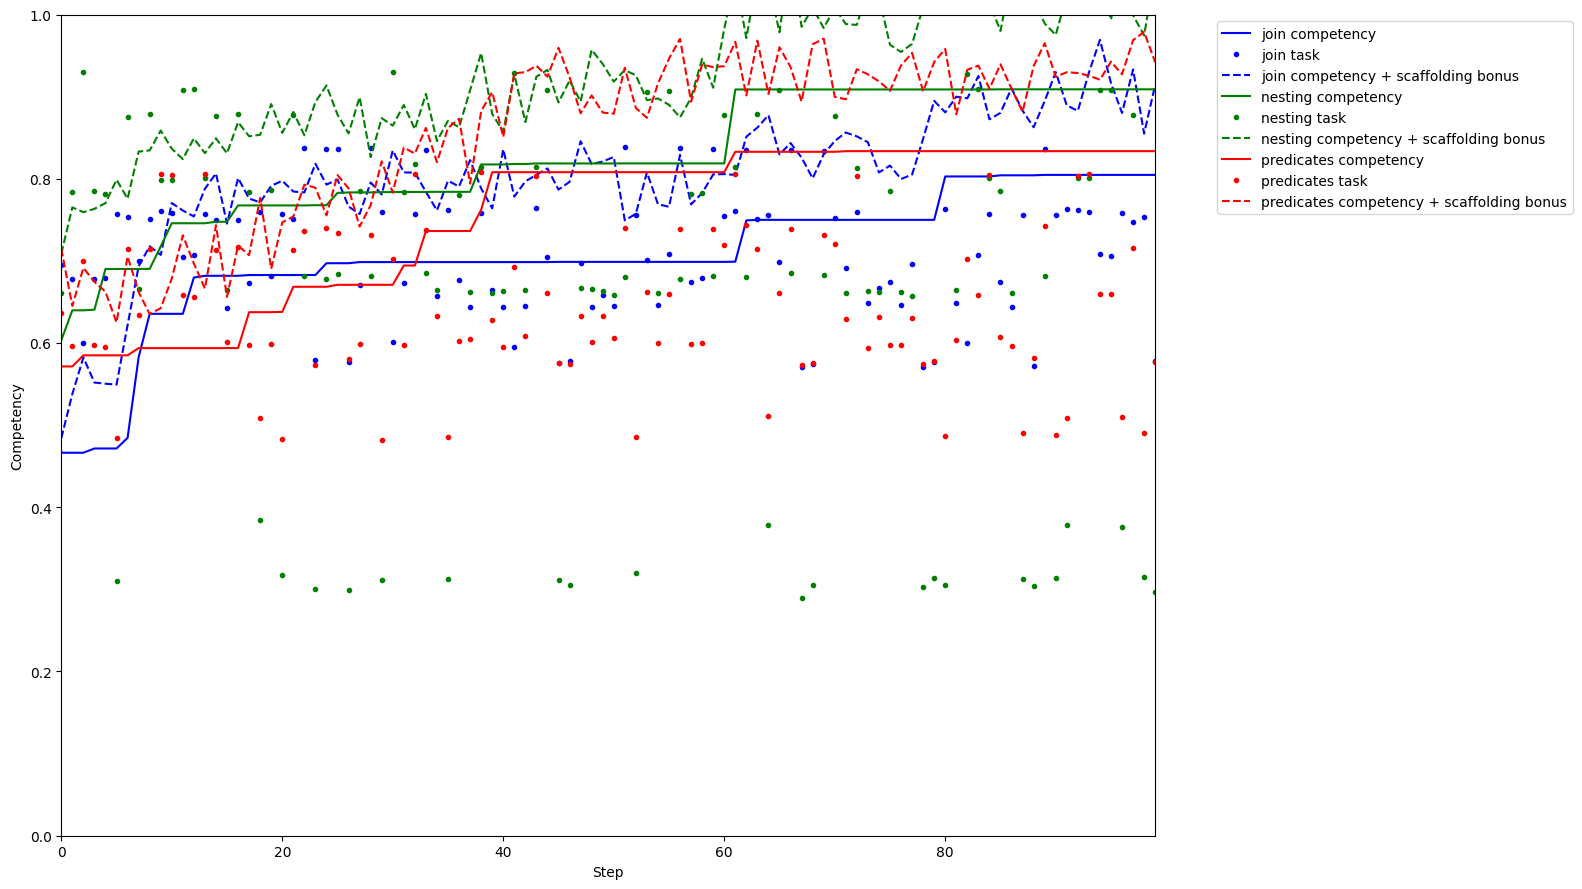

In [5]:
plot_simulation_log(log_optimal, 1)
plot_simulation_log(log_random, 1)
plot_simulation_log(log_dkt, 1)